# Load Test deployed web application

This notebook pulls some images and tests them against the deployed web application. We submit requests asychronously which should reduce the contribution of latency.

In [2]:
import os
from timeit import default_timer
import pandas as pd

import matplotlib.pyplot as plt
from azureml.core.webservice import AksWebservice
from azureml.core.workspace import Workspace
from dotenv import get_key, find_dotenv
from testing_utilities import to_img, gen_variations_of_one_image, get_auth
from urllib.parse import urlparse

%matplotlib inline

In [3]:
env_path = find_dotenv(raise_error_if_not_found=True)

In [4]:
ws = Workspace.from_config(auth=get_auth())
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep="\n")

Found the config file in: /data/home/mat/repos/AKSDeploymentTutorialAML/{{cookiecutter.project_name}}/Keras_Tensorflow/aml_config/config.json
workspace
msakstest
eastus
edf507a2-6235-46c5-b560-fd463ba2e771


Let's retrive the web service.

In [5]:
aks_service_name = get_key(env_path, 'aks_service_name')
aks_service = AksWebservice(ws, name=aks_service_name)

We will test our service concurrently but only have 4 concurrent requests at any time. We have only deployed one pod on one node and increasing the number of concurrent calls does not really increase throughput. Feel free to try different values and see how the service responds.

In [6]:
CONCURRENT_REQUESTS = 4   # Number of requests at a time

Get the scoring URL and API key of the service.

In [7]:
scoring_url = aks_service.scoring_uri
api_key = aks_service.get_keys()[0]

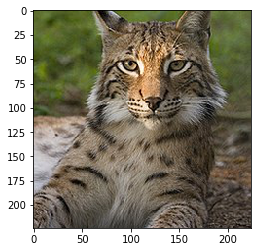

In [8]:
IMAGEURL = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg"
plt.imshow(to_img(IMAGEURL))

Below we are going to use [Locust](https://locust.io/) to load test our deployed model. First we need to write the locustfile. We will use variations of the same image to test the service.

In [9]:
%%writefile locustfile.py
from locust import HttpLocust, TaskSet, task
from testing_utilities import gen_variations_of_one_image
import os
from itertools import cycle


_IMAGEURL = os.getenv('IMAGEURL', "https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg")
_NUMBER_OF_VARIATIONS = os.getenv('NUMBER_OF_VARIATIONS', 100)
_SCORE_PATH = os.getenv('SCORE_PATH', "/score")
_API_KEY = os.getenv('API_KEY')


class UserBehavior(TaskSet):
    def on_start(self):
        print('Running setup')
        self._image_generator =  cycle(gen_variations_of_one_image(_IMAGEURL, _NUMBER_OF_VARIATIONS))
        self._headers = {'Authorization':('Bearer {}'.format(_API_KEY))}
        
    @task
    def score(self):
        self.client.post(_SCORE_PATH, files={'image': next(self._image_generator)}, headers=self._headers)


class WebsiteUser(HttpLocust):
    task_set = UserBehavior
    # min and max time to wait before repeating task
    min_wait = 10
    max_wait = 200

Overwriting locustfile.py


Below we define the locust command we want to run. We are going to run at a hatch rate of 10 and the whole test will last 1 minute. Feel free to adjust the parameters below and see how the results differ. The results of the test will be saved to two csv files **modeltest_requests.csv** and **modeltest_distribution.csv**

In [10]:
parsed_url = urlparse(scoring_url)
cmd = "locust -H {host} --no-web -c {users} -r {rate} -t {duration} --csv=modeltest --only-summary".format(
    host="{url.scheme}://{url.netloc}".format(url=parsed_url),
    users=CONCURRENT_REQUESTS,  # concurrent users
    rate=10,                    # hatch rate (users / second)
    duration='1m',              # test duration
)

In [11]:
! API_KEY={api_key} SCORE_PATH={parsed_url.path} PYTHONPATH={os.path.abspath('../')} {cmd}

[2019-05-07 18:14:59,817] msvole2/INFO/locust.main: Run time limit set to 60 seconds
[2019-05-07 18:14:59,817] msvole2/INFO/locust.main: Starting Locust 0.11.0
[2019-05-07 18:14:59,817] msvole2/INFO/locust.runners: Hatching and swarming 4 clients at the rate 10 clients/s...
[2019-05-07 18:14:59,818] msvole2/INFO/stdout: Running setup
[2019-05-07 18:14:59,818] msvole2/INFO/stdout: 
[2019-05-07 18:15:00,108] msvole2/INFO/stdout: Running setup
[2019-05-07 18:15:00,108] msvole2/INFO/stdout: 
[2019-05-07 18:15:00,385] msvole2/INFO/stdout: Running setup
[2019-05-07 18:15:00,386] msvole2/INFO/stdout: 
[2019-05-07 18:15:00,665] msvole2/INFO/stdout: Running setup
[2019-05-07 18:15:00,665] msvole2/INFO/stdout: 
[2019-05-07 18:15:00,945] msvole2/INFO/locust.runners: All locusts hatched: WebsiteUser: 4
[2019-05-07 18:15:59,817] msvole2/INFO/locust.main: Time limit reached. Stopping Locust.
[2019-05-07 18:15:59,818] msvole2/INFO/locust.main: Shutting down (exit code 0), bye.
[2019-05-07 18:15:59,81

Here are the summary results of our test and below that the distribution infromation of those tests. 

In [12]:
pd.read_csv("modeltest_requests.csv")

,Method,Name,# requests,# failures,Median response time,Average response time,Min response time,Max response time,Average Content Size,Requests/s
0,POST,/api/v1/service/askservice/score,806,0,180,184,86,436,181,13.62
1,None,Total,806,0,180,184,86,436,181,13.62


In [13]:
pd.read_csv("modeltest_distribution.csv")

,Name,# requests,50%,66%,75%,80%,90%,95%,98%,99%,100%
0,POST /api/v1/service/askservice/score,806,180,200,210,220,250,270,290,310,440
1,Total,806,180,200,210,220,250,270,290,310,440


To tear down the cluster and all related resources go to the [tear down the cluster](07_TearDown.ipynb) notebook.